# Run

## Imports

In [1]:
! pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.7 MB/s eta 0:00:00


In [2]:
# Ставим зависимости
!apt-get install -y build-essential
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib-0.4.0/
!./configure --prefix=/usr
!make
!make install
%cd ..
# Устанавливаем python-обертку
!pip install Ta-Lib
import talib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
--2025-09-29 01:42:24--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-09-29 01:42:24--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.n

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import talib
import random
import datetime
import time
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## Funcrions

### Get Binance klines

In [8]:
from datetime import timezone, datetime
import os
import requests
import zipfile
import csv
import io
from dateutil.relativedelta import relativedelta

def generate_months(start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m')
    end_date = datetime.strptime(end_date, '%Y-%m')
    months = []

    while start_date <= end_date:
        months.append(start_date.strftime('%Y-%m'))
        start_date = start_date + relativedelta(months=1)

    return months


# Загрузка данных с Binance
def download_klines(symbol, interval, start_date, end_date):
    months = generate_months(start_date, end_date)
    if not os.path.exists('klines'):
        os.mkdir('klines')

    klines = {
        'Date': [], 'Open': [], 'High': [], 'Low': [], 'Close': [], 'Volume': []
    }

    for month in months:
        filename = f"{symbol}-{interval}-{month}.zip"
        file_path = f"klines/{filename}"

        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            url = f"https://data.binance.vision/data/futures/um/monthly/klines/{symbol}/{interval}/{filename}"
            try:
                r = requests.get(url, allow_redirects=True)
                with open(file_path, 'wb') as f:
                    f.write(r.content)
            except Exception as e:
                print(f"Ошибка загрузки файла {filename}: {e}. Пропускаем.")
                continue

        try:
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                with zip_file.open(f"{symbol}-{interval}-{month}.csv", 'r') as csv_file:
                    csv_reader = csv.reader(io.TextIOWrapper(csv_file, 'utf-8'))
                    for row in csv_reader:
                        if row[0].isdigit():
                            klines['Date'].append(datetime.fromtimestamp(int(row[0]) / 1000, tz=timezone.utc))
                            klines['Open'].append(float(row[1]))
                            klines['High'].append(float(row[2]))
                            klines['Low'].append(float(row[3]))
                            klines['Close'].append(float(row[4]))
                            klines['Volume'].append(float(row[5]))
        except (zipfile.BadZipFile, KeyError):
            print(f"Ошибка: Файл {file_path} поврежден или не является ZIP. Пропускаем.")
            continue


    if not klines['Date']:
        raise ValueError(f"Нет доступных данных для {symbol} в диапазоне {start_date} - {end_date}")

    df = pd.DataFrame(klines)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

### Candle patterns

In [89]:
import numpy as np
import pandas as pd

def detect_candlestick_patterns(df,
                                doji_th=0.1,               # doji: тело <= 10% от range
                                hammer_lower_mult=2.0,     # lower_shadow >= 2 * body
                                hammer_upper_mult=0.3,     # upper_shadow <= 0.3 * body
                                small_body_factor=0.5,     # middle candle size relative threshold for morning star
                                min_body_pct=0.2):         # minimum body size relative to candle range for "strong" bodies
    # ASSUME df has numeric columns: 'open','high','low','close'
    df = df.copy()

    o = df['open'].astype(float)
    h = df['high'].astype(float)
    l = df['low'].astype(float)
    c = df['close'].astype(float)

    prev_o = o.shift(1)
    prev_h = h.shift(1)
    prev_l = l.shift(1)
    prev_c = c.shift(1)

    pre_prev_o = o.shift(2)
    pre_prev_c = c.shift(2)

    # basic measures
    df['body'] = c - o
    df['body_abs'] = df['body'].abs()
    df['range'] = (h - l).replace(0, np.nan)   # avoid div by zero, keep NaN for zero-range
    df['upper_shadow'] = h - np.maximum(o, c)
    df['lower_shadow'] = np.minimum(o, c) - l
    df['body_pct_of_range'] = df['body_abs'] / df['range']

    # DOJI (relative to candle range)
    df['doji'] = (df['range'].isna() & (df['body_abs'] == 0)) | (df['body_abs'] <= doji_th * df['range'])

    # HAMMER (both bullish or bearish allowed)
    hammer_cond = (
        (df['lower_shadow'] >= hammer_lower_mult * df['body_abs']) &
        (df['upper_shadow'] <= hammer_upper_mult * df['body_abs']) &
        (df['body_pct_of_range'] <= 0.5)   # body not too large relative to range
    )
    df['hammer'] = hammer_cond

    # INVERTED HAMMER
    inv_hammer_cond = (
        (df['upper_shadow'] >= hammer_lower_mult * df['body_abs']) &
        (df['lower_shadow'] <= hammer_upper_mult * df['body_abs']) &
        (df['body_pct_of_range'] <= 0.5)
    )
    df['inverted_hammer'] = inv_hammer_cond

    # BULLISH ENGULFING
    prev_body_abs = (prev_c - prev_o).abs()
    bull_engulf = (
        (prev_c < prev_o) &           # previous bearish
        (c > o) &                     # current bullish
        (o < prev_c) &                # current open below previous close (i.e. below previous body top)
        (c > prev_o) &                # current close above previous open (engulf)
        (df['body_abs'] > prev_body_abs)  # optional: current body bigger than previous
    )
    df['bullish_engulfing'] = bull_engulf.fillna(False)

    # PIERCING LINE (classic definition)
    piercing = (
        (prev_c < prev_o) &  # prev bearish
        (o < prev_l) &       # current open below previous low (gap down) -- can relax to prev_c if desired
        (c > (prev_o + prev_c) / 2)  # close into upper half of previous body
    )
    df['piercing_line'] = piercing.fillna(False)

    # MORNING STAR (3-candle pattern)
    # 1) pre_prev bearish
    # 2) previous small body relative to pre_prev
    # 3) current bullish and closes above midpoint of pre_prev body
    prev_body_abs = (prev_c - prev_o).abs()
    pre_prev_body_abs = (pre_prev_c - pre_prev_o).abs()
    morning_star = (
        (pre_prev_c < pre_prev_o) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (c > o) &
        (o < prev_c) &  # current opens below previous close (gap or inside)
        (c > (pre_prev_o + pre_prev_c) / 2)
    )
    df['morning_star'] = morning_star.fillna(False)

    # THREE WHITE SOLDIERS (vectorized)
    o0 = o.shift(2); o1 = o.shift(1); o2 = o
    c0 = c.shift(2); c1 = c.shift(1); c2 = c
    body0 = (c0 - o0).abs(); body1 = (c1 - o1).abs(); body2 = (c2 - o2).abs()
    three_ws = (
        (c0 > o0) & (c1 > o1) & (c2 > o2) &               # all bullish
        (c2 > c1) & (c1 > c0) &                            # ascending closes
        (o1 > o0) & (o2 > o1) &                            # opens move upward
        (body0 >= min_body_pct * (h.shift(2) - l.shift(2)).replace(0, np.nan)) &
        (body1 >= min_body_pct * (h.shift(1) - l.shift(1)).replace(0, np.nan)) &
        (body2 >= min_body_pct * (h - l).replace(0, np.nan)) &
        (o1 < c0) & (o2 < c1)                              # opens within previous bodies (not strict gap)
    )
    df['three_white_soldiers'] = three_ws.fillna(False)

    # HARAMI CROSS (doji inside previous real body) — generalized both directions
    prev_body_top = np.maximum(prev_o, prev_c)
    prev_body_bottom = np.minimum(prev_o, prev_c)
    harami_cross = (
        df['is_doji'] &
        (df['high'] < prev_body_top) &
        (df['low'] > prev_body_bottom) &
        (prev_body_abs >= (min_body_pct * df['range'].shift(1)))  # prev body not tiny
    )
    df['harami_cross'] = harami_cross.fillna(False)

    # clean helper columns if you like
    df = df.drop(columns=['body','body_abs','range','upper_shadow','lower_shadow','body_pct_of_range'])
    return df


In [ ]:
# # functions for calculating patterns
# import pandas as pd

# def is_doji(row, threshold=0.1):
#     return abs(row['open'] - row['close']) <= threshold

# def is_hammer(row):
#     body = abs(row['open'] - row['close'])
#     lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
#     upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
#     return lower_shadow > 2 * body and upper_shadow < body

# def is_bullish_engulfing(current_row, previous_row):
#     return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
#            current_row['open'] < previous_row['close'] and current_row['close'] > previous_row['open']

# def is_piercing_line(current_row, previous_row):
#     return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
#             current_row['open'] < previous_row['low'] and current_row['close'] > (previous_row['open'] + previous_row['close']) / 2

# def is_morning_star(current_row, previous_row, pre_previous_row):
#     return pre_previous_row['close'] < pre_previous_row['open'] and \
#           abs(previous_row['close'] - previous_row['open']) < abs(pre_previous_row['close'] - pre_previous_row['open']) / 2 and \
#           current_row['close'] > current_row['open'] and \
#           current_row['open'] < previous_row['close'] and \
#           current_row['close'] > (previous_row['close'] + previous_row['open']) / 2

# def is_inverted_hammer(row):
#     body = abs(row['open'] - row['close'])
#     upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
#     lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
#     return upper_shadow > 2 * body and lower_shadow < body

# def is_three_white_soldiers(df, idx):
#     if idx < 2:
#         return False
#     current = df.iloc[idx]
#     prev1 = df.iloc[idx - 1]
#     prev2 = df.iloc[idx - 2]
#     return all([current['close'] > current['open'], prev1['close'] > prev1['open'], prev2['close'] > prev2['open']]) and \
#            all([current['open'] > prev1['close'], prev1['open'] > prev2['close']]) and \
#            all([current['close'] > prev1['close'], prev1['close'] > prev2['close']])

# def is_harami_cross(current_row, previous_row):
#     return abs(current_row['open'] - current_row['close']) < (current_row['high'] - current_row['low']) * 0.1 and \
#            previous_row['open'] > previous_row['close'] and current_row['high'] < previous_row['open' ] and current_row['low'] > previous_row['close']

# data['doji'] = data.apply(is_doji, axis=1)
# data['hammer'] = data.apply(is_hammer, axis=1)
# data['bull_engulfing'] = data.apply(lambda row: is_bullish_engulfing(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
# data['piercing_line'] = data.apply(lambda row: is_piercing_line(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
# data['morning_star'] = data.apply(lambda row: is_morning_star(row, data.iloc[data.index.get_loc(row.name) - 1], data.iloc[data.index.get_loc(row.name) - 2]) if data.index.get_loc(row.name) > 1 else False, axis=1)
# data['inverted_hammer'] = data.apply(is_inverted_hammer, axis=1)
# data['three_white_soldiers'] = data.apply(lambda row: is_three_white_soldiers(data, data.index.get_loc(row.name)), axis=1)
# data['harami_cross'] = data.apply(lambda row: is_harami_cross(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)

In [79]:
from ast import pattern
# Function for analyzing candlestick patterns

def plot_random_pattern(data, pattern_column, pattern_name):
    patterns = data[data[pattern_column] != 0]

    if patterns.empty:
      print(f"No occurences of {pattern_name} pattern found.")
      return

    random_index = random.choice(patterns.index)
    start_index = max(0, data.index.get_loc(random_index) - 20)
    end_index = min(len(data), data.index.get_loc(random_index) + 20)

    data_window = data.iloc[start_index:end_index+1]

    fig, axlist = mpf.plot(data_window, type='candle', style='nightclouds', volume=True,
                          title=f'{pattern_name} Pattern Detection at {random_index.date()}',
                          show_nontrading=True, returnfig=True, figsize=(12,6))

    axes = axlist[0]
    pattern_row = data.loc[random_index]

    # Add a short line to a candlestick plot
    axes.annotate('', xy=(random_index, pattern_row['high']),
                  xytext=(random_index, pattern_row['high'] + 0.15), # set the line size
                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->', lw=1.5))

    axes.text(random_index, pattern_row['high'] + 0.2, pattern_name,
              horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='magenta')


## Data extraction

In [64]:
# Data extraction
symbol = 'SOLUSDT'
interval = '4h'
start_date = '2022-09'
end_date = '2025-08'

data = download_klines(symbol, interval, start_date, end_date)

In [ ]:
# check and remove duplicates in index
data = data[~data.index.duplicated(keep='first')]

In [65]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2022-09-01 00:00:00+00:00,31.47,31.75,30.94,31.20,3196484.00
2022-09-01 04:00:00+00:00,31.20,31.53,30.80,31.05,2259614.00
2022-09-01 08:00:00+00:00,31.05,31.57,30.82,31.44,2538901.00
2022-09-01 12:00:00+00:00,31.44,31.48,30.37,30.75,4947419.00
2022-09-01 16:00:00+00:00,30.75,31.08,30.44,31.05,3253585.00
...,...,...,...,...,...
2025-08-31 04:00:00+00:00,205.48,205.57,202.66,203.44,2540429.87
2025-08-31 08:00:00+00:00,203.44,205.77,202.06,203.55,3178529.23
2025-08-31 12:00:00+00:00,203.56,204.80,201.39,204.48,3684150.02


In [66]:
data.columns = data.columns.str.lower()
data.head()

,open,high,low,close,volume
Date,,,,,
2022-09-01 00:00:00+00:00,31.47,31.75,30.94,31.20,3196484.0
2022-09-01 04:00:00+00:00,31.20,31.53,30.80,31.05,2259614.0
2022-09-01 08:00:00+00:00,31.05,31.57,30.82,31.44,2538901.0
2022-09-01 12:00:00+00:00,31.44,31.48,30.37,30.75,4947419.0
2022-09-01 16:00:00+00:00,30.75,31.08,30.44,31.05,3253585.0


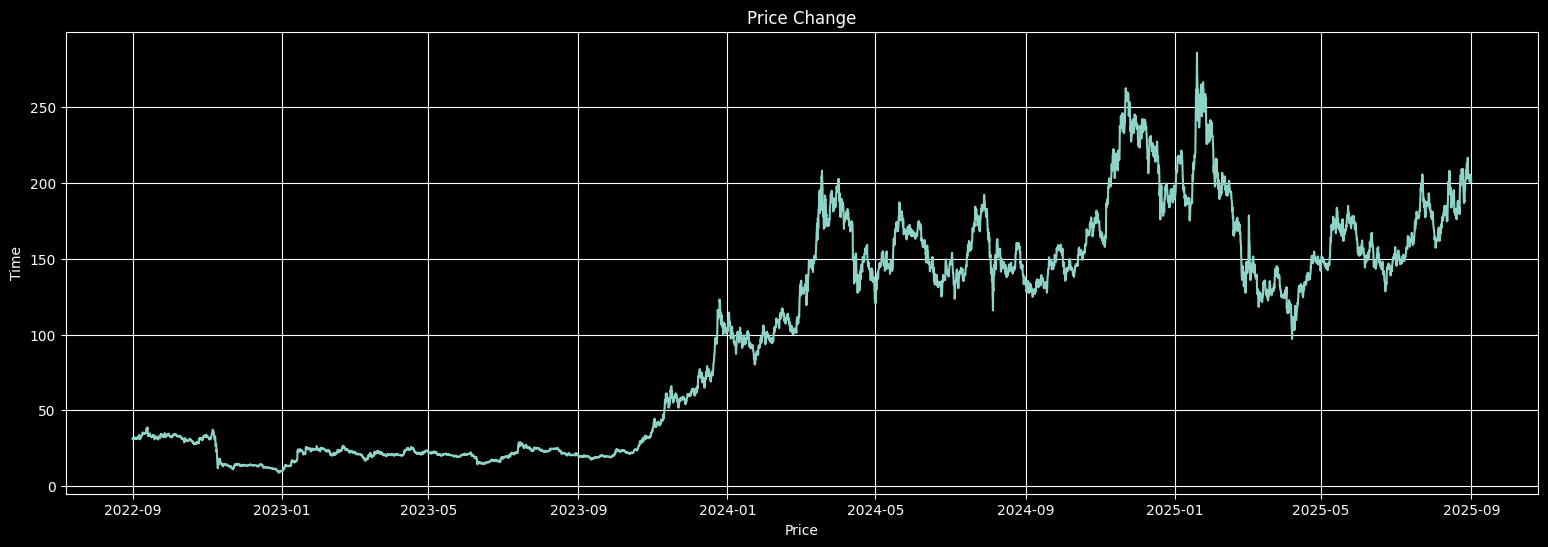

In [46]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(19,6))
plt.plot(data.index, data['close'])
plt.xlabel('Price')
plt.ylabel('Time')
plt.title('Price Change')
plt.grid()
plt.show()


## Candle patterns

In [90]:
data = detect_candlestick_patterns(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6576 entries, 2022-09-01 00:00:00+00:00 to 2025-08-31 20:00:00+00:00
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     6576 non-null   float64
 1   high                     6576 non-null   float64
 2   low                      6576 non-null   float64
 3   close                    6576 non-null   float64
 4   volume                   6576 non-null   float64
 5   return                   6575 non-null   float64
 6   price_change             6575 non-null   float64
 7   binary_target            6576 non-null   int64  
 8   is_doji                  6576 non-null   bool   
 9   is_hammer                6576 non-null   bool   
 10  is_inverted_hammer       6576 non-null   bool   
 11  is_bullish_engulfing     6576 non-null   bool   
 12  is_piercing_line         6576 non-null   bool   
 13  is_morning_star          6576 

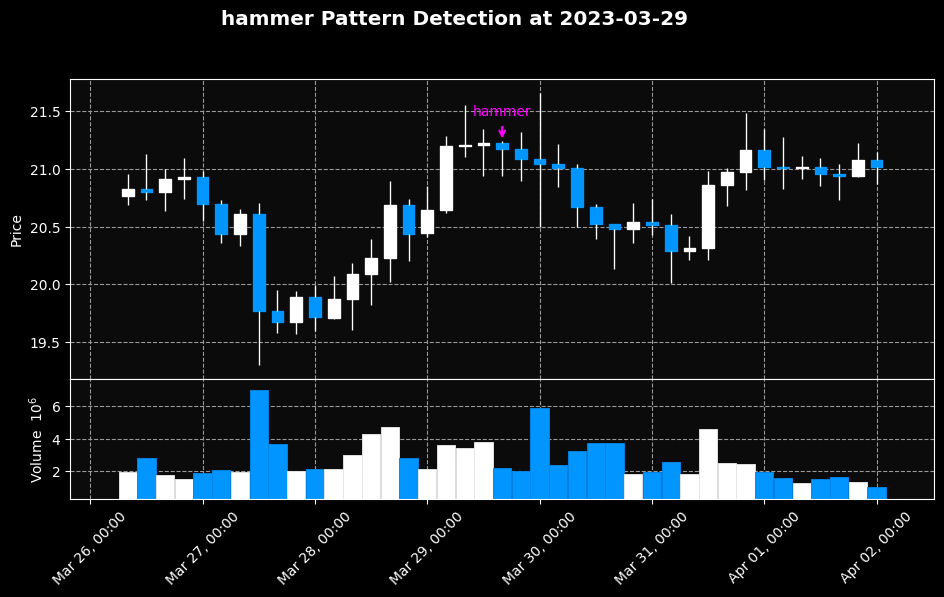

In [91]:
# display a random pattern
plot_random_pattern(data, 'hammer', 'hammer')

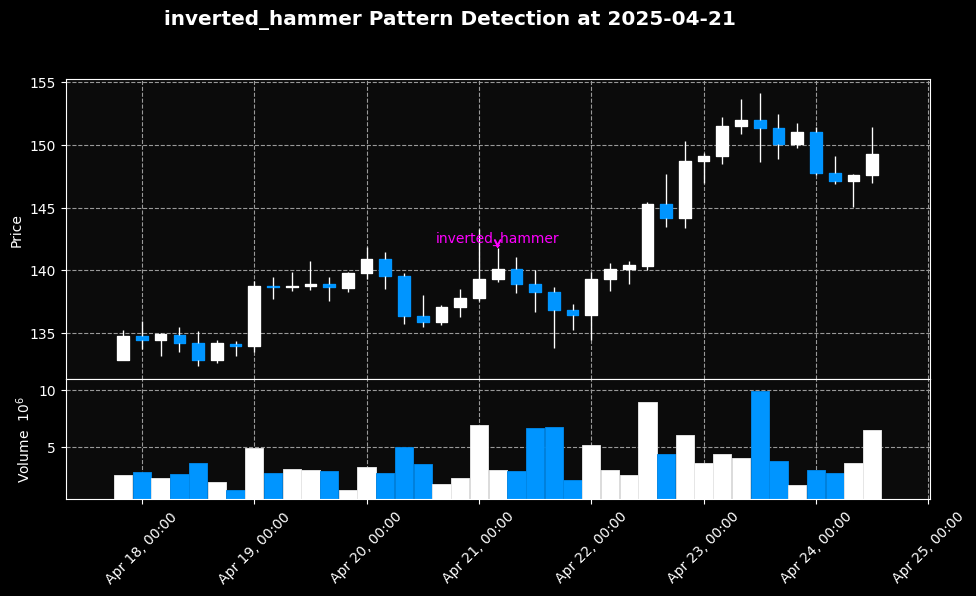

In [98]:
plot_random_pattern(data, 'inverted_hammer', 'inverted_hammer')

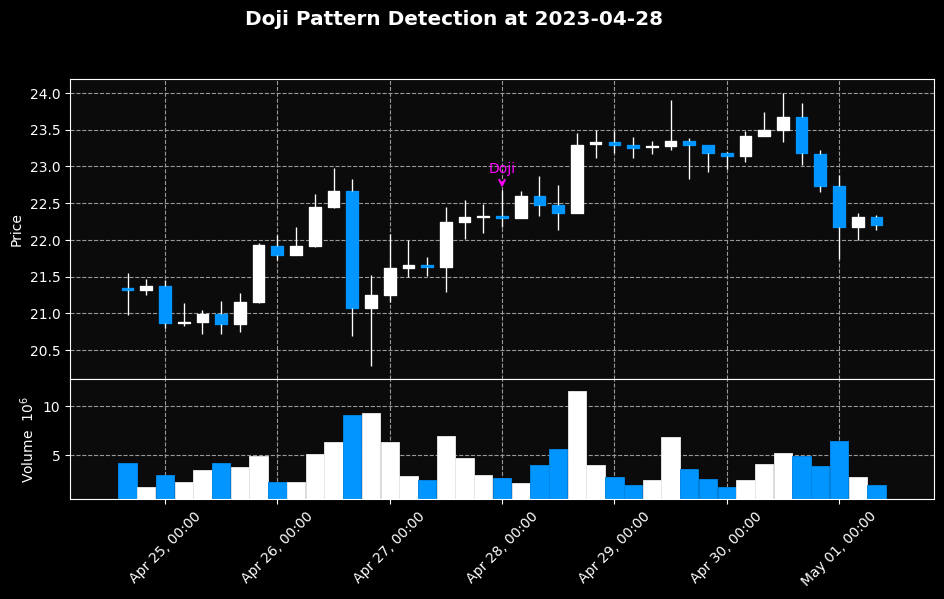

In [92]:
plot_random_pattern(data, 'doji', 'Doji')

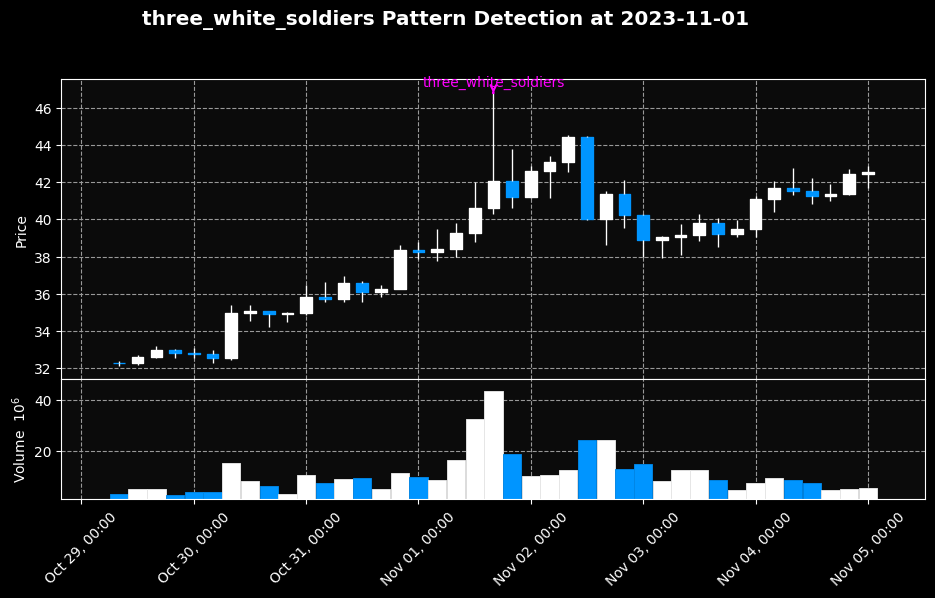

In [93]:
plot_random_pattern(data, 'three_white_soldiers', 'three_white_soldiers')

In [94]:
plot_random_pattern(data, 'harami_cross', 'harami_cross')

No occurences of harami_cross pattern found.


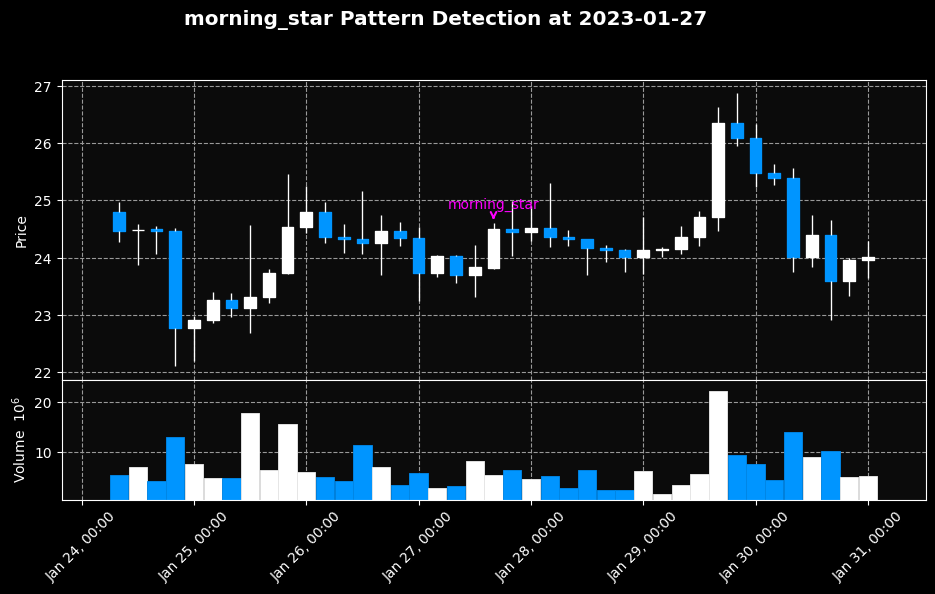

In [95]:
plot_random_pattern(data, 'morning_star', 'morning_star')

In [97]:
plot_random_pattern(data, 'piercing_line', 'piercing_line')

No occurences of piercing_line pattern found.


In [106]:
doji_count = len(data[data["doji"] == True])
hammer_count = len(data[data["hammer"] == True])
inverted_hammer_count = len(data[data["inverted_hammer"] == True])
three_white_soldiers_count = len(data[data["three_white_soldiers"] == True])
harami_cross_count = len(data[data["harami_cross"] == True])
morning_star_count = len(data[data["morning_star"] == True])
piercing_line_count = len(data[data["piercing_line"] == True])


print(f'Doji patterns: {doji_count}\n'
      f'Hammer patterns: {hammer_count}\n'
      f'Inverted hammer patterns: {inverted_hammer_count}\n'
      f'Three white soldiers patterns: {three_white_soldiers_count}\n'
      f'Harami cross patterns: {harami_cross_count}\n'
      f'Morning star patterns: {morning_star_count}\n'
      f'Piercing line patterns: {piercing_line_count}\n\n'

      f'Total patterns: {hammer_count + inverted_hammer_count + doji_count + three_white_soldiers_count + harami_cross_count + morning_star_count + piercing_line_count}')

Doji patterns: 716
Hammer patterns: 117
Inverted hammer patterns: 55
Three white soldiers patterns: 24
Harami cross patterns: 0
Morning star patterns: 79
Piercing line patterns: 0

Total patterns: 991


## Percentage price change algorithm

In [67]:
# data['return'] is the future return of the next candle relative to the current closing price.
data['return'] = data['close'].pct_change().shift(-1)

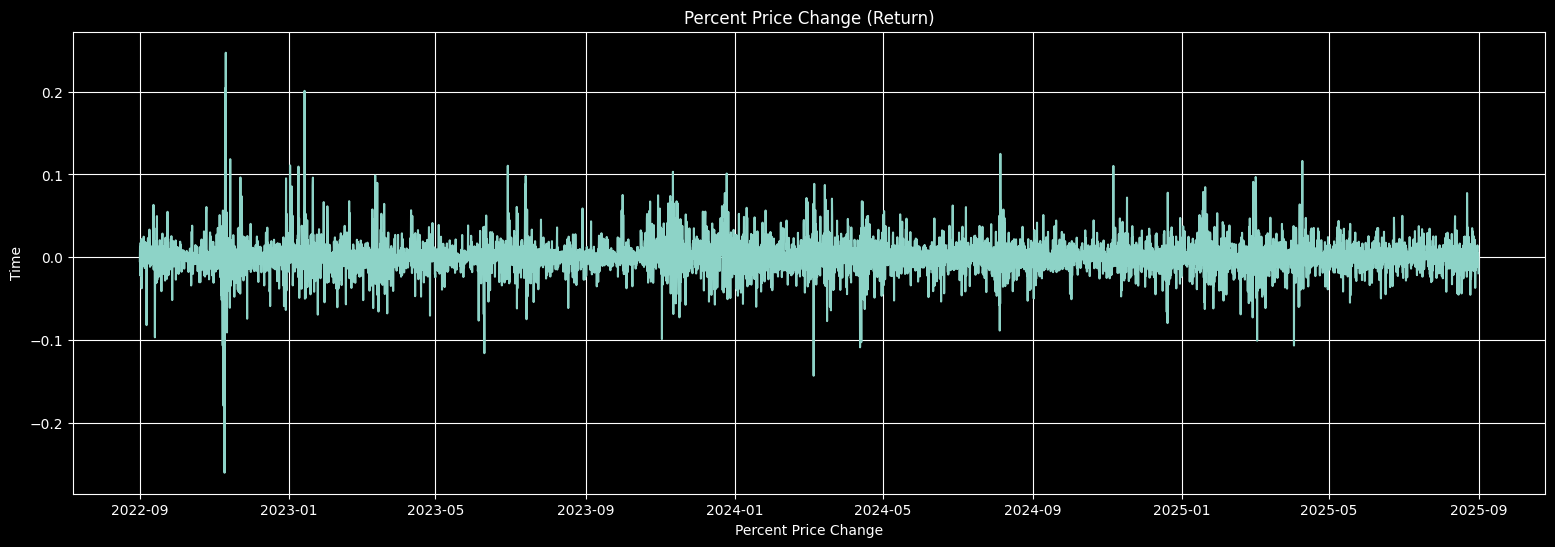

In [68]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(19,6))
plt.plot(data.index, data['return'])
plt.xlabel('Percent Price Change')
plt.ylabel('Time')
plt.title('Percent Price Change (Return)')
plt.grid()
plt.show()


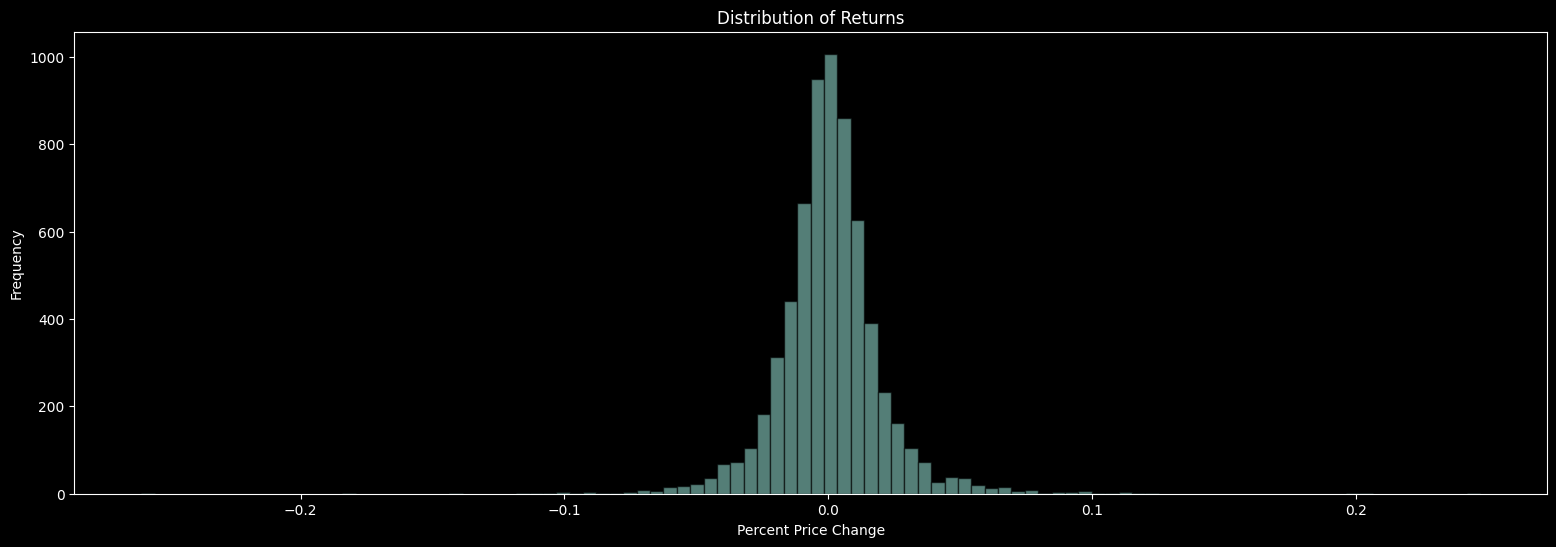

In [69]:
# simple yield calculation
fig, ax = plt.subplots(figsize=(19, 6))
plt.hist(data['return'], bins=100, edgecolor='black', alpha=0.6)
plt.xlabel('Percent Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Returns')
plt.show()

Based on the graph, we can judge that the profitability has a normal distribution.

If the price per hour increases by half a percent, then put the mark 1, otherwise mark 0

In [70]:
precentage_chage = 0.005 # 0.5%

# set the mark
data['price_change'] = data['close'].pct_change() # percentage price change
data['binary_target'] = np.where(data['price_change'].shift(-1) > precentage_chage, 1, 0)

In [73]:
data.head()

,open,high,low,close,volume,return,price_change,binary_target,is_doji,is_hammer,is_inverted_hammer,is_bullish_engulfing,is_piercing_line,is_morning_star,is_three_white_soldiers,is_harami_cross
Date,,,,,,,,,,,,,,,,
2022-09-01 00:00:00+00:00,31.47,31.75,30.94,31.20,3196484.0,-0.004808,NaN,0,False,False,False,False,False,False,False,False
2022-09-01 04:00:00+00:00,31.20,31.53,30.80,31.05,2259614.0,0.012560,-0.004808,1,False,False,False,False,False,False,False,False
2022-09-01 08:00:00+00:00,31.05,31.57,30.82,31.44,2538901.0,-0.021947,0.012560,0,False,False,False,False,False,False,False,False
2022-09-01 12:00:00+00:00,31.44,31.48,30.37,30.75,4947419.0,0.009756,-0.021947,1,False,False,False,False,False,False,False,False
2022-09-01 16:00:00+00:00,30.75,31.08,30.44,31.05,3253585.0,0.017391,0.009756,1,False,False,False,False,False,False,False,False


## Indicators

In [112]:
# indecators culculations
data['ATR'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)
data['historical_volatility'] = talib.NATR(data['high'], data['low'], data['close'], timeperiod=14)
data['SMA_10'] = talib.SMA(data['close'], timeperiod=10)
data['SMA_30'] = talib.SMA(data['close'], timeperiod=30)
data['SMA_50'] = talib.SMA(data['close'], timeperiod=50)
data['SMA_100'] = talib.SMA(data['close'], timeperiod=100)
data['SMA_200'] = talib.SMA(data['close'], timeperiod=100)
data['EMA_10'] = talib.EMA(data['close'], timeperiod=10)
data['EMA_30'] = talib.EMA(data['close'], timeperiod=30)
data['EMA_50'] = talib.EMA(data['close'], timeperiod=50)
data['EMA_100'] = talib.EMA(data['close'], timeperiod=100)
data['EMA_200'] = talib.SMA(data['close'], timeperiod=100)
data['RSI_14'] = talib.RSI(data['close'], timeperiod=14)
data['MACD'], data['MACD_signal'], _ = talib.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['bollinger_high'], data['bollinger_mid'], data['bollinger_low'] = talib.BBANDS(data['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
data['volume_mean_10'] = data['volume'].rolling(window=10).mean()
data['volume_mean_30'] = data['volume'].rolling(window=30).mean()
data['parabolic_SAR'] = talib.SAR(data['high'], data['low'], acceleration=0.02, maximum=0.2)
data['ADX'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)
data['CCI'] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=14)
data['stochastic_oscillator_k'], data['stochastic_oscillator_d'] = talib.STOCH(data['high'], data['low'], data['close'],
                                                                               fastk_period=14, slowk_period=3, slowk_matype=0,
                                                                               slowd_period=3, slowd_matype=0)



# Removing rows with NaN values
data.dropna(inplace=True)
data

,open,high,low,close,volume,return,price_change,binary_target,is_doji,is_hammer,...,bollinger_mid,bollinger_low,volume_mean_10,volume_mean_30,parabolic_SAR,ADX,CCI,stochastic_oscillator_k,stochastic_oscillator_d,EMA_200
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-04 00:00:00+00:00,32.88,33.15,32.82,33.09,1653559.00,0.018737,0.006081,1,False,False,...,32.7180,32.087933,2479670.600,3.110316e+06,31.781184,23.105586,115.311909,83.106961,77.796901,32.8446
2022-10-04 04:00:00+00:00,33.09,33.78,32.94,33.71,3238425.00,-0.002077,0.018737,0,False,False,...,32.7425,32.006976,2616801.800,3.122721e+06,31.839537,22.146178,181.012326,88.130884,83.345455,32.8489
2022-10-04 08:00:00+00:00,33.70,33.87,33.38,33.64,2329561.00,0.015458,-0.002077,1,False,False,...,32.7710,31.947959,2639796.500,3.105990e+06,31.955964,21.431372,164.875944,92.140947,87.792931,32.8529
2022-10-04 12:00:00+00:00,33.65,34.37,33.53,34.16,3907318.00,-0.002342,0.015458,0,False,False,...,32.8290,31.809532,2736720.900,2.965981e+06,32.109087,21.648474,177.698200,92.754813,91.008881,32.8579
2022-10-04 16:00:00+00:00,34.16,34.23,33.77,34.08,3084077.00,0.000000,-0.002342,0,False,False,...,32.8825,31.727374,2816564.700,2.869132e+06,32.335179,21.850070,142.490842,90.264275,91.720011,32.8647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-31 00:00:00+00:00,202.59,206.64,202.58,205.48,4436602.18,-0.009928,0.014265,0,False,False,...,207.0360,197.934894,5686262.807,6.696761e+06,207.777110,18.623699,-18.029758,27.517869,21.503494,194.5593
2025-08-31 04:00:00+00:00,205.48,205.57,202.66,203.44,2540429.87,0.000541,-0.009928,0,False,False,...,207.0610,198.002389,4390687.167,6.656965e+06,206.742399,17.961354,-29.250307,31.221572,26.294130,194.6453
2025-08-31 08:00:00+00:00,203.44,205.77,202.06,203.55,3178529.23,0.004569,0.000541,0,True,False,...,206.8350,197.663526,3887245.096,6.647786e+06,206.640000,17.189320,-18.715728,32.824822,30.521421,194.7519


In [110]:
data.head(3)

,open,high,low,close,volume,return,price_change,binary_target,is_doji,is_hammer,...,bollinger_high,bollinger_mid,bollinger_low,volume_mean_10,volume_mean_30,parabolic_SAR,ADX,CCI,stochastic_oscillator_k,stochastic_oscillator_d
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-17 12:00:00+00:00,32.61,33.30,32.50,33.28,2061236.0,-0.001202,0.020546,0,False,False,...,34.344315,33.100,31.855685,2395145.9,3.898337e+06,31.542568,23.043141,31.448696,42.649404,37.201542
2022-09-17 16:00:00+00:00,33.28,33.60,33.07,33.24,1982959.0,0.012635,-0.001202,1,True,False,...,34.345731,33.101,31.856269,2299097.2,3.817662e+06,31.612865,21.658636,110.923803,52.232737,43.733516
2022-09-17 20:00:00+00:00,33.25,33.88,33.15,33.66,1529230.0,-0.007724,0.012635,0,False,False,...,34.365883,33.109,31.852117,2302199.1,3.783861e+06,31.732093,20.265880,148.230759,71.266734,55.382958


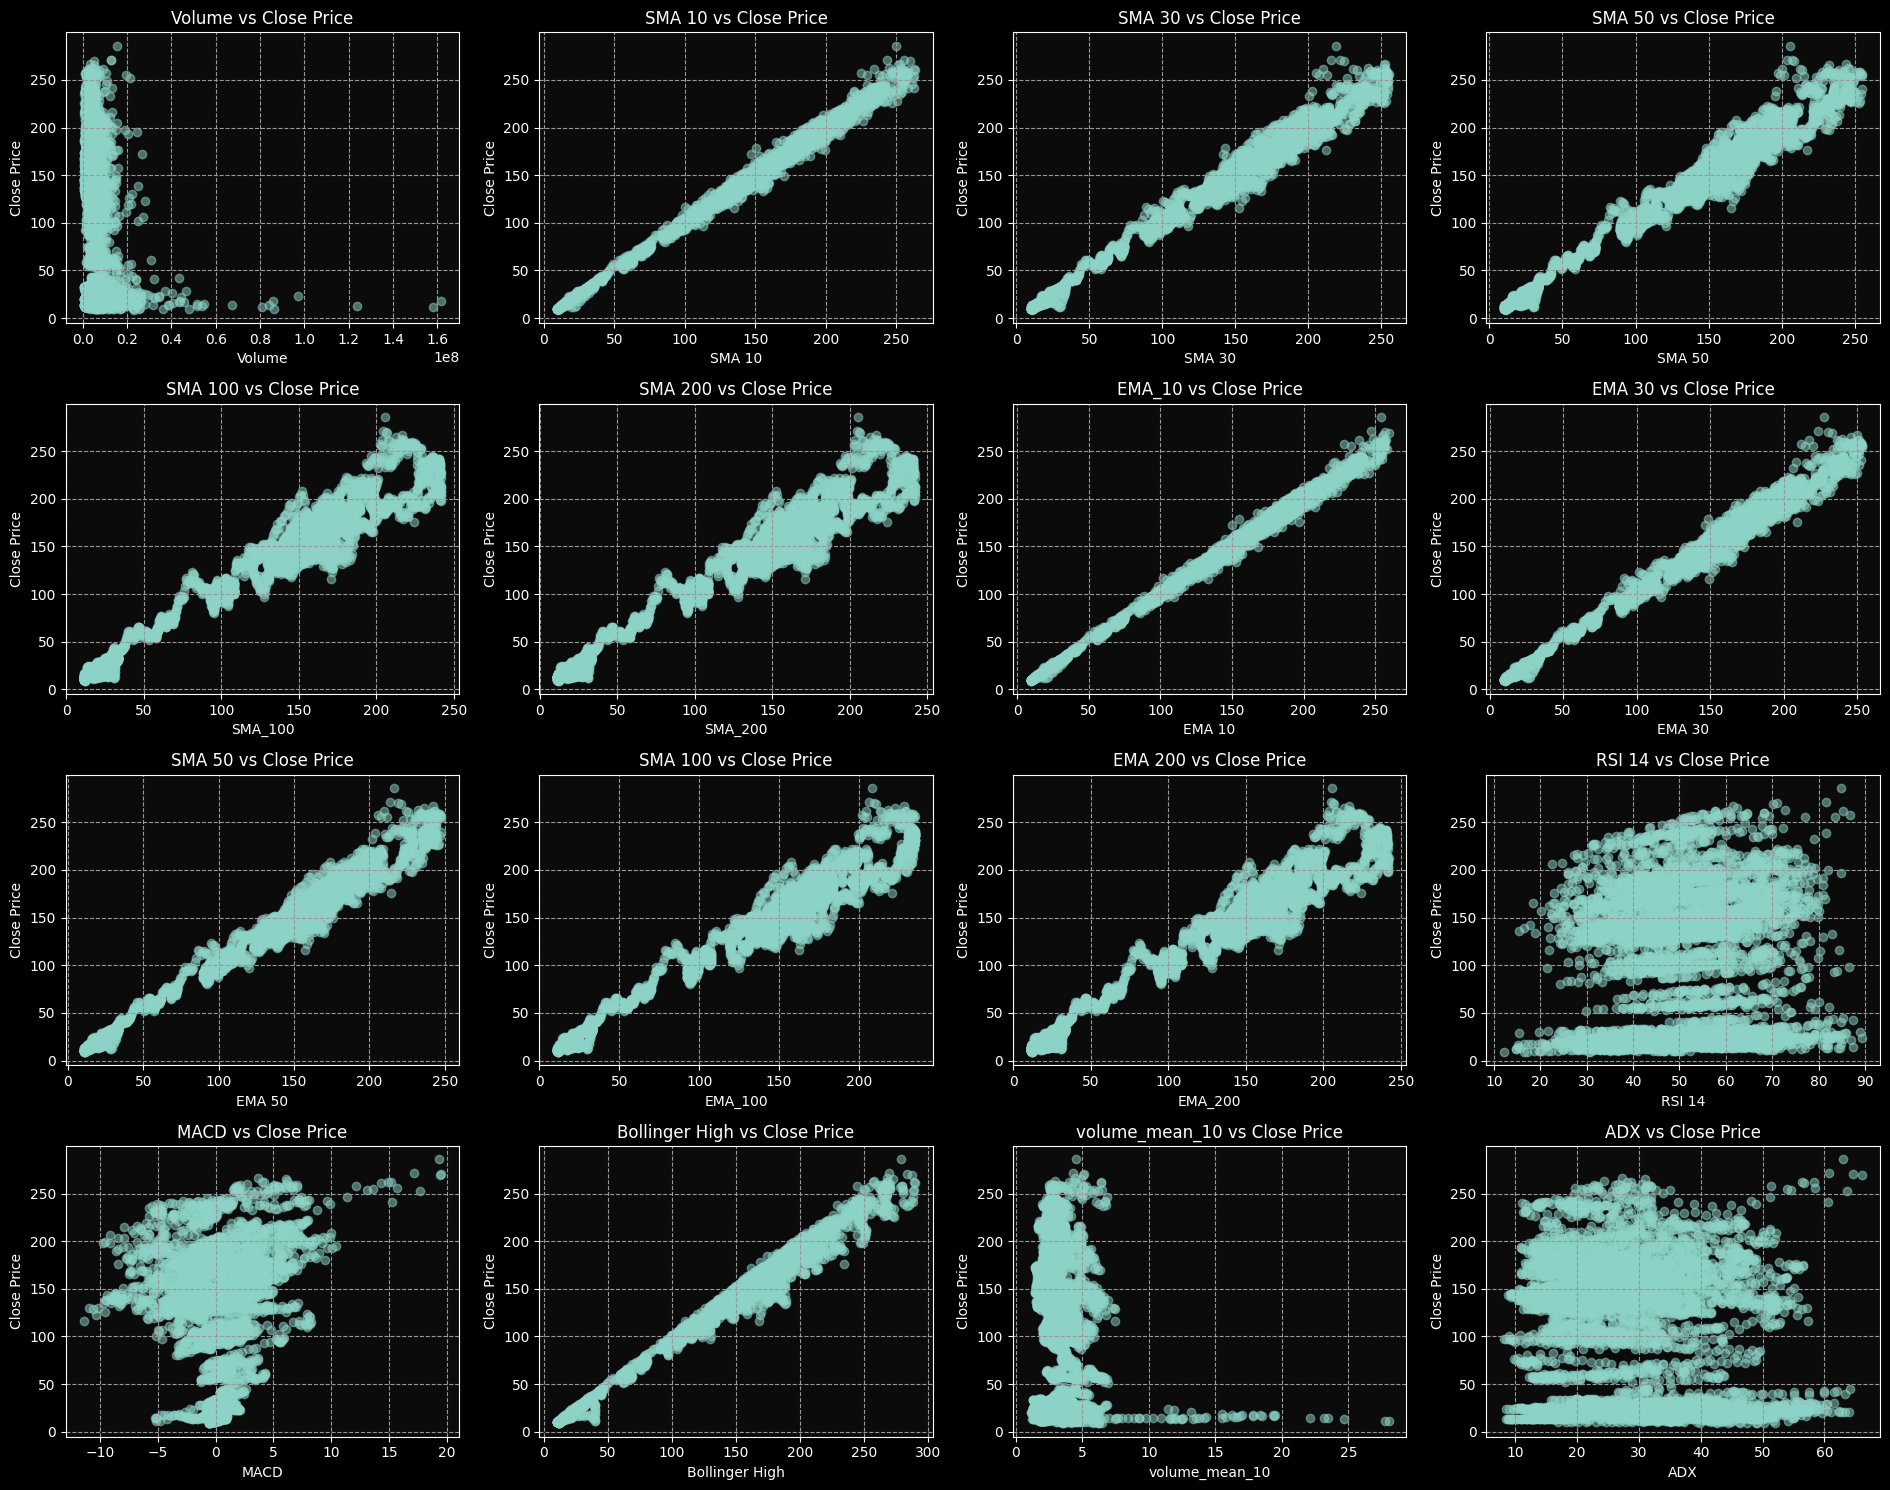

In [113]:
# Visualizing indicators
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(19, 15))


# Scatter plot: Close price vs volume
axes[0, 0].scatter(data['volume'], data['close'], alpha=0.5)
axes[0, 0].set_xlabel('Volume')
axes[0, 0].set_ylabel('Close Price')
axes[0, 0].set_title('Volume vs Close Price')
axes[0, 0].grid(True)

axes[0, 1].scatter(data['SMA_10'], data['close'], alpha=0.5)
axes[0, 1].set_xlabel('SMA 10')
axes[0, 1].set_ylabel('Close Price')
axes[0, 1].set_title('SMA 10 vs Close Price')
axes[0, 1].grid(True)

axes[0, 2].scatter(data['SMA_30'], data['close'], alpha=0.5)
axes[0, 2].set_xlabel('SMA 30')
axes[0, 2].set_ylabel('Close Price')
axes[0, 2].set_title('SMA 30 vs Close Price')
axes[0, 2].grid(True)

axes[0, 3].scatter(data['SMA_50'], data['close'], alpha=0.5)
axes[0, 3].set_xlabel('SMA 50')
axes[0, 3].set_ylabel('Close Price')
axes[0, 3].set_title('SMA 50 vs Close Price')
axes[0, 3].grid(True)

axes[1, 0].scatter(data['SMA_100'], data['close'], alpha=0.5)
axes[1, 0].set_xlabel('SMA_100')
axes[1, 0].set_ylabel('Close Price')
axes[1, 0].set_title('SMA 100 vs Close Price')
axes[1, 0].grid(True)

axes[1, 1].scatter(data['SMA_200'], data['close'], alpha=0.5)
axes[1, 1].set_xlabel('SMA_200')
axes[1, 1].set_ylabel('Close Price')
axes[1, 1].set_title('SMA 200 vs Close Price')
axes[1, 1].grid(True)


axes[1, 2].scatter(data['EMA_10'], data['close'], alpha=0.5)
axes[1, 2].set_xlabel('EMA 10')
axes[1, 2].set_ylabel('Close Price')
axes[1, 2].set_title('EMA_10 vs Close Price')
axes[1, 2].grid(True)

axes[1, 3].scatter(data['EMA_30'], data['close'], alpha=0.5)
axes[1, 3].set_xlabel('EMA 30')
axes[1, 3].set_ylabel('Close Price')
axes[1, 3].set_title('EMA 30 vs Close Price')
axes[1, 3].grid(True)

axes[2, 0].scatter(data['EMA_50'], data['close'], alpha=0.5)
axes[2, 0].set_xlabel('EMA 50')
axes[2, 0].set_ylabel('Close Price')
axes[2, 0].set_title('SMA 50 vs Close Price')
axes[2, 0].grid(True)

axes[2, 1].scatter(data['EMA_100'], data['close'], alpha=0.5)
axes[2, 1].set_xlabel('EMA_100')
axes[2, 1].set_ylabel('Close Price')
axes[2, 1].set_title('SMA 100 vs Close Price')
axes[2, 1].grid(True)

axes[2, 2].scatter(data['EMA_200'], data['close'], alpha=0.5)
axes[2, 2].set_xlabel('EMA_200')
axes[2, 2].set_ylabel('Close Price')
axes[2, 2].set_title('EMA 200 vs Close Price')
axes[2, 2].grid(True)


axes[2,  3].scatter(data['RSI_14'], data['close'], alpha=0.5)
axes[2,  3].set_xlabel('RSI 14')
axes[2,  3].set_ylabel('Close Price')
axes[2,  3].set_title('RSI 14 vs Close Price')
axes[2,  3].grid(True)


axes[3, 0].scatter(data['MACD'], data['close'], alpha=0.5)
axes[3, 0].set_xlabel('MACD')
axes[3, 0].set_ylabel('Close Price')
axes[3, 0].set_title('MACD vs Close Price')
axes[3, 0].grid(True)


axes[3, 1].scatter(data['bollinger_high'], data['close'], alpha=0.5)
axes[3, 1].set_xlabel('Bollinger High')
axes[3, 1].set_ylabel('Close Price')
axes[3, 1].set_title('Bollinger High vs Close Price')
axes[3, 1].grid(True)


axes[3, 2].scatter(data['historical_volatility'], data['close'], alpha=0.5)
axes[3, 2].set_xlabel('volume_mean_10')
axes[3, 2].set_ylabel('Close Price')
axes[3, 2].set_title('volume_mean_10 vs Close Price')
axes[3, 2].grid(True)


axes[3, 3].scatter(data['ADX'], data['close'], alpha=0.5)
axes[3, 3].set_xlabel('ADX')
axes[3, 3].set_ylabel('Close Price')
axes[3, 3].set_title('ADX vs Close Price')
axes[3, 3].grid(True)

plt.tight_layout()
plt.show()

## Data splitting

In [ ]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return', 'price_change',
       'binary_target', 'SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal',
       'bollinger_high', 'bollinger_mid', 'bollinger_low', 'doji', 'hammer',
       'bull_engulfing', 'piercing_line', 'morning_star', 'inverted_hammer',
       'three_white_soldiers', 'harami_cross', 'ATR', 'historical_volatility',
       'volume_mean_10', 'volume_mean_30', 'parabolic_SAR', 'ADX',
       'stochastic_oscillator_k', 'stochastic_oscillator_d', 'CCI', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200'],
      dtype='object')

In [ ]:
features = ['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal',
       'bollinger_high', 'bollinger_mid', 'bollinger_low', 'doji', 'hammer',
       'bull_engulfing', 'piercing_line', 'morning_star', 'inverted_hammer',
       'three_white_soldiers', 'harami_cross', 'ATR', 'historical_volatility',
       'volume_mean_10', 'volume_mean_30', 'parabolic_SAR', 'ADX',
       'stochastic_oscillator_k', 'stochastic_oscillator_d', 'CCI', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200']

X = data[features]
y = data['binary_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Train and evaluation

In [ ]:

import xgboost as xgb
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from tabulate import tabulate

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Accuracy  | 0.562696 |
+-----------+----------+
| Precision | 0.375309 |
+-----------+----------+
| Recall    | 0.332604 |
+-----------+----------+
| F1        | 0.352668 |
+-----------+----------+
| ROC AUC   | 0.5314   |
+-----------+----------+


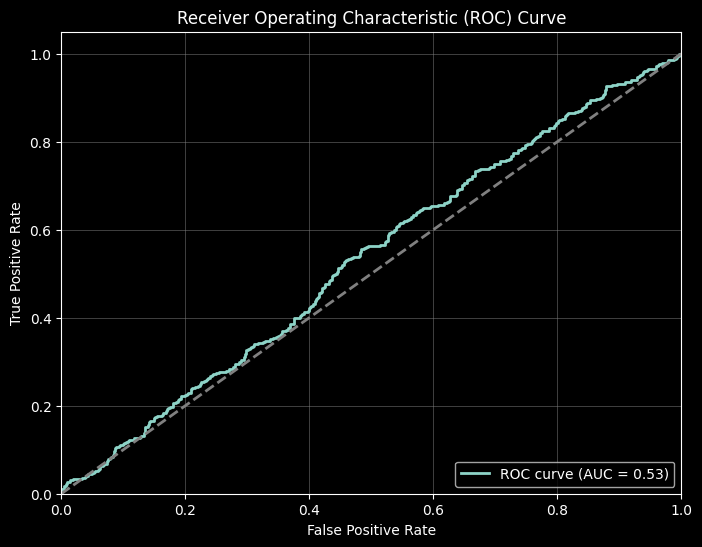


Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  566 |                  253 |
+-----------------+----------------------+----------------------+
| Actual Positive |                  305 |                  152 |
+-----------------+----------------------+----------------------+


In [ ]:
metrics_table = [
    ['Accuracy', accuracy],
    ['Precision', precision],
    ['Recall', recall],
    ['F1', f1],
    ['ROC AUC', roc_auc]
]

print(tabulate(metrics_table, headers=['Metric', 'Value'], tablefmt='grid'))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_table = [['', 'Predicted Negative', 'Predicted Positive'],
                     ['Actual Negative', conf_matrix[0][0], conf_matrix[0][1]],
                     ['Actual Positive', conf_matrix[1][0], conf_matrix[1][1]]
                     ]

print('\nConfusion Matrix:')
print(tabulate(conf_matrix_table, headers='firstrow', tablefmt='grid'))

## Backtest

In [ ]:
! pip install backtrader
import backtrader as bt

In [ ]:
# Creating a Dataframe with test data and predictions

test_data = data.loc[X_test.index].copy()
test_data['predictions'] = y_pred

# Converting data to backtrader format
class CustomPandasData(bt.feeds.PandasData):
    lines = ('predictions',)
    params = (
        ('predictions', -1),
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', None),
    )

In [ ]:
class MLStrategy(bt.Strategy):
    params = (
        ('stop_loss', 0.01), # 1% stop loss
        ('take_profit', 0.1), # 10% take profit
        ('stake', 1000) # position size in dollars
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.predictions = self.datas[0].predictions
        self.order = None # checking for existing order
        self.price = None
        self.stop_price = None
        self.take_profit_price = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return # orders sent / accepted by broker

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
                self.price = order.executed.price
                self.stop_price = self.price * (1.0 - self.params.stop_loss)
                self.take_profit_price = self.price * (1.0 + self.params.take_profit)
            elif order.issell():
                self.log(f"SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
            self.order = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def next(self):
        if self.order:
            return

        if not self.position:
            if self.predictions[0] > 0:
                self.order = self.buy(size=self.params.stake / self.dataclose[0])
                self.log(f'BUY CREATED, Price: {self.dataclose[0]:.2f}')

        else:
            if self.dataclose[0] <= self.stop_price or self.dataclose[0] >= self.take_profit_price:
                self.order = self.sell(size=self.position.size)
                self.log(f'SELL CREATED, Price: {self.dataclose[0]:.2f}')

        # Output current portfolio value for debugging
        self.log(f'Position Value: {self.broker.getvalue():.2f}')

In [ ]:
# Create Cerebro and add data and strategy
cerebro = bt.Cerebro()
cerebro.addstrategy(MLStrategy)


# Convert data to backtrader format
datafeed = CustomPandasData(dataname=test_data)
cerebro.adddata(datafeed)

# Add Observer to track profile cost
cerebro.addobserver(bt.observers.Value)

# Initial funds
cerebro.broker.set_cash(10000.0)

# Set Commision
cerebro.broker.setcommission(commission=0.001)


# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
strategies = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Getting profile values ​​and dates from Observer
portfolio_values = [ob for ob in strategies[0].observers if isinstance(ob, bt.observers.Value)][0].lines.value.get(0, size=len(test_data))
portfolio_dates = test_data.index[:len(portfolio_values)]

Starting Portfolio Value: 10000.00
2025-01-31 Position Value: 10000.00
2025-01-31 Position Value: 10000.00
2025-01-31 Position Value: 10000.00
2025-01-31 BUY CREATED, Price: 230.34
2025-01-31 Position Value: 10000.00
2025-01-31 BUY EXECUTED, Price: 230.34, Cost: 1000.00, Comm: 1.00
2025-01-31 Position Value: 10004.43
2025-02-01 Position Value: 10003.47
2025-02-01 Position Value: 9999.91
2025-02-01 SELL CREATED, Price: 227.98
2025-02-01 Position Value: 9988.75
2025-02-01 SELL EXECUTED, Price: 227.98, Cost: 1000.00, Comm: 0.99
2025-02-01 OPERATION PROFIT, GROSS -10.25, NET -12.24
2025-02-01 Position Value: 9987.76
2025-02-01 BUY CREATED, Price: 221.63
2025-02-01 Position Value: 9987.76
2025-02-01 BUY EXECUTED, Price: 221.62, Cost: 999.95, Comm: 1.00
2025-02-01 SELL CREATED, Price: 212.89
2025-02-01 Position Value: 9947.37
2025-02-02 SELL EXECUTED, Price: 212.88, Cost: 999.95, Comm: 0.96
2025-02-02 OPERATION PROFIT, GROSS -39.44, NET -41.40
2025-02-02 BUY CREATED, Price: 206.99
2025-02-02

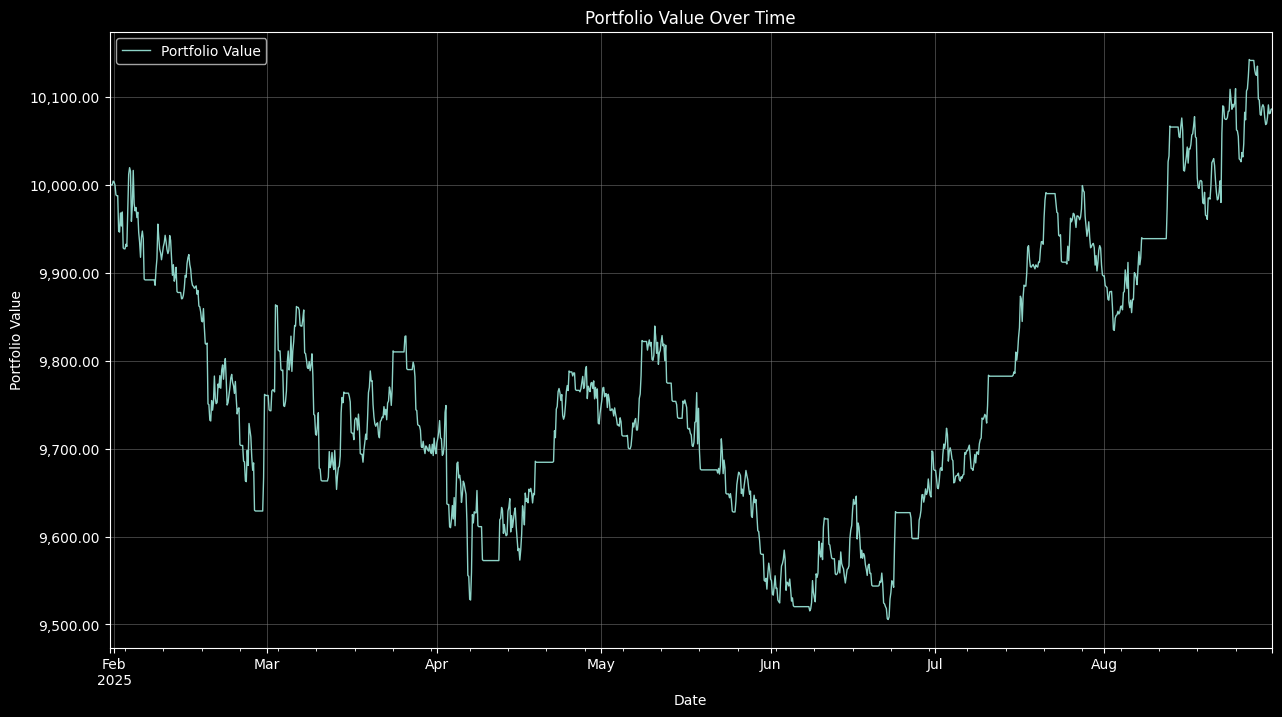

In [ ]:
# Creating a Dataframe with portfolio values and predictions

portfolio_df = pd.DataFrame({'Date': portfolio_dates, 'portfolio_value': portfolio_values})
portfolio_df.set_index('Date', inplace=True)

%matplotlib inline
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
portfolio_df['portfolio_value'].plot(label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))
plt.legend()
plt.show()

## Log profobility

log_return = log(close t+1 / close t) - логорифм от часовой доходности 4:30